In [1]:
import pandas as pd
from datasets import load_dataset
from sklearn.model_selection import train_test_split

data = load_dataset('banking77')
all_data = pd.DataFrame(data['train']).append(pd.DataFrame(data['test']))

all_data.describe()

Using custom data configuration default
Reusing dataset banking77 (C:\Users\anmol\.cache\huggingface\datasets\banking77\default\1.1.0\aec0289529599d4572d76ab00c8944cb84f88410ad0c9e7da26189d31f62a55b)


  0%|          | 0/2 [00:00<?, ?it/s]

,label
count,13083.000000
mean,37.733700
std,22.352789
min,0.000000
25%,18.000000
50%,37.000000
75%,57.000000
max,76.000000


In [2]:
# check if any label or text is null

print('Null count for any text', all_data['text'].isnull().sum())
print('Null Count for any labels ', all_data['label'].isnull().sum())

Null count for any text 0
Null Count for any labels  0


In [3]:
# check total no of unique labels

print('Unique labels ', len(all_data['label'].unique()))

Unique labels  77


In [4]:
# Convert all text data to lower case
all_data['text'] = all_data['text'].str.lower()

all_data.head()

,text,label
0,i am still waiting on my card?,11
1,what can i do if my card still hasn't arrived ...,11
2,i have been waiting over a week. is the card s...,11
3,can i track my card while it is in the process...,11
4,"how do i know if i will get my card, or if it ...",11


<AxesSubplot:>

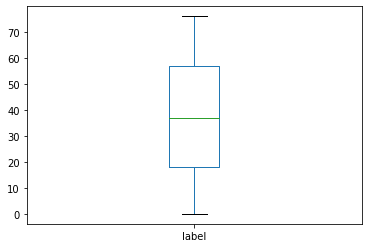

In [5]:
# box plot of the label

all_data[['label']].plot.box()

<AxesSubplot:title={'center':'Labels Distribution'}, ylabel='Frequency'>

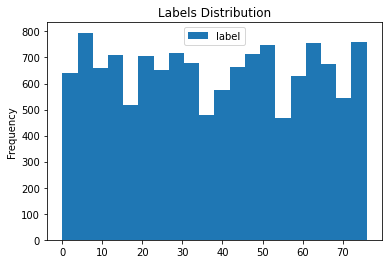

In [6]:
all_data[['label']].plot.hist(bins = 20, title = 'Labels Distribution')

In [7]:
# split data using sklearn
train_text, test_text, train_labels, test_labels = train_test_split(all_data['text'], all_data['label'], test_size=0.20, random_state=42, stratify=all_data['label'])
# stratified train test split


# creating train data and text dataframes
train_data = pd.DataFrame({'text': [], 'label': []})
test_data = pd.DataFrame({'text': [], 'label': []})

# assigining splitted data to dataframes
train_data['text'] = train_text
train_data['label'] = train_labels
test_data['text'] = test_text
test_data['label'] = test_labels

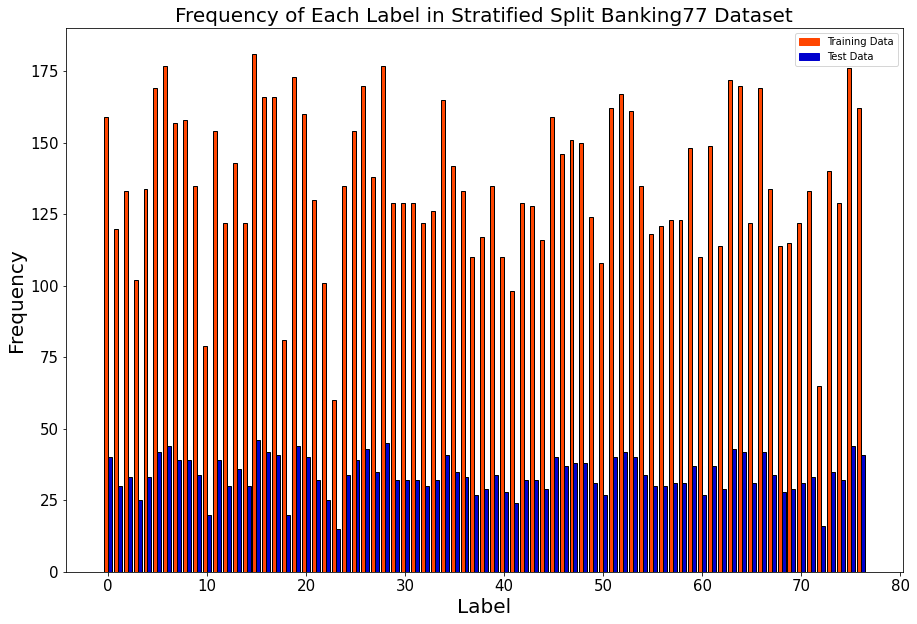

In [8]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

labels = range(0, 77)
train_label_counts = list(pd.DataFrame(train_data['label'].value_counts()).sort_index()['label'])
test_label_counts = list(pd.DataFrame(test_data['label'].value_counts()).sort_index()['label'])

plt.rcParams['figure.figsize'] = [15, 10]
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['ytick.labelsize'] = 15

train_patch = mpatches.Patch(color='orangered', label='Training Data')
test_patch = mpatches.Patch(color='mediumblue', label='Test Data')
plt.legend(handles=[train_patch, test_patch])

plt.bar(labels, train_label_counts, width=-0.4, color='orangered', edgecolor='black', align='edge')
plt.bar(labels, test_label_counts, width=0.4, color='mediumblue', edgecolor='black', align='edge')
plt.xlabel('Label')
plt.ylabel('Frequency')
plt.title('Frequency of Each Label in Stratified Split Banking77 Dataset')
plt.show()

In [23]:
import tensorflow as tf
from transformers import TFDistilBertModel

train_data = train_data.sample(frac=1, random_state=10)

# Set up DistilBERT part of the model
dbert_model = TFDistilBertModel.from_pretrained('distilbert-base-uncased')

# get distilbert 
input_ids = tf.keras.Input(shape=(98,), name='input_token', dtype='int32')
input_masks = tf.keras.Input(shape=(98,), name='masked_token', dtype='int32')
# configure inputs
dbert_layer = dbert_model(input_ids, attention_mask=input_masks)[0][:,0,:]
# output layer of distilbert to be input to the neural network on top

# setting up neural network layers
dropout = tf.keras.layers.Dropout(0.1)(dbert_layer)

# add some dropout for robustness
output_layer = tf.keras.layers.Dense(
    77, 
    activation='softmax', 
    kernel_regularizer='l2'
    )(dropout)
# output layer, fully connected, with 77 neurons since there are 77 output classes

# compile model
realistic_model = tf.keras.Model(inputs=[input_ids, input_masks], outputs=output_layer)

for layer in realistic_model.layers[:2]:
    layer.trainable = False

sched_lr = tf.keras.optimizers.schedules.CosineDecay(     # learning rate schedule for Adam optimizer
      initial_learning_rate=0.0001,   # initial learning rate, quite large
      decay_steps=314*10,    # roughly 314 steps per epoch, want it to decay over 10 epochs 
      alpha=0.01      # want minimum learning rate to be alpha*initial_learning_rate
      )

sched_opt = tf.keras.optimizers.Adam(learning_rate=sched_lr)    # 0.0001

realistic_model.compile(
    optimizer=sched_opt, 
    loss='categorical_crossentropy', # categorical crossentropy is to be minimised since we have 77 categories to classify into
    metrics=['categorical_accuracy']  # again, this is a categorical classification task
    )

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_projector', 'vocab_layer_norm', 'activation_13', 'vocab_transform']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


In [24]:
import pandas as pd
import numpy as np
from transformers import DistilBertTokenizer

# tokenize text using the model
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

train_text = tokenizer(
    list(train_data['text']), 
    add_special_tokens=True, 
    max_length=98, 
    padding='max_length', 
    truncation=True, 
    return_tensors='tf'
)

test_text = tokenizer(
    list(train_data['text']), 
    add_special_tokens=True, 
    max_length=98, 
    padding='max_length', 
    truncation=True, 
    return_tensors='tf'
)

# one hot encoding of the label
train_labels = tf.keras.utils.to_categorical(train_data['label'])
test_labels = tf.keras.utils.to_categorical(train_data['label'])


In [25]:
realistic_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_token (InputLayer)       [(None, 98)]         0           []                               
                                                                                                  
 masked_token (InputLayer)      [(None, 98)]         0           []                               
                                                                                                  
 tf_distil_bert_model_1 (TFDist  TFBaseModelOutput(l  66362880   ['input_token[0][0]',            
 ilBertModel)                   ast_hidden_state=(N               'masked_token[0][0]']           
                                one, 98, 768),                                                    
                                 hidden_states=None                                         

In [27]:
history = realistic_model.fit(
    [train_text['input_ids'], train_text['attention_mask']], 
    train_labels,
    batch_size=30,
    epochs=5,
    verbose=2,
    validation_split=0.1
)

Epoch 1/5
314/314 - 1548s - loss: 1.3498 - categorical_accuracy: 0.9292 - val_loss: 1.3599 - val_categorical_accuracy: 0.8902 - 1548s/epoch - 5s/step
Epoch 2/5
314/314 - 1543s - loss: 1.0161 - categorical_accuracy: 0.9678 - val_loss: 1.1581 - val_categorical_accuracy: 0.9026 - 1543s/epoch - 5s/step
Epoch 3/5
314/314 - 1545s - loss: 0.7911 - categorical_accuracy: 0.9860 - val_loss: 1.0067 - val_categorical_accuracy: 0.9074 - 1545s/epoch - 5s/step
Epoch 4/5
314/314 - 1545s - loss: 0.6350 - categorical_accuracy: 0.9942 - val_loss: 0.8999 - val_categorical_accuracy: 0.9131 - 1545s/epoch - 5s/step
Epoch 5/5
314/314 - 1547s - loss: 0.5315 - categorical_accuracy: 0.9970 - val_loss: 0.8023 - val_categorical_accuracy: 0.9188 - 1547s/epoch - 5s/step


In [28]:
realistic_model.save_weights("categorical_pred_weights")

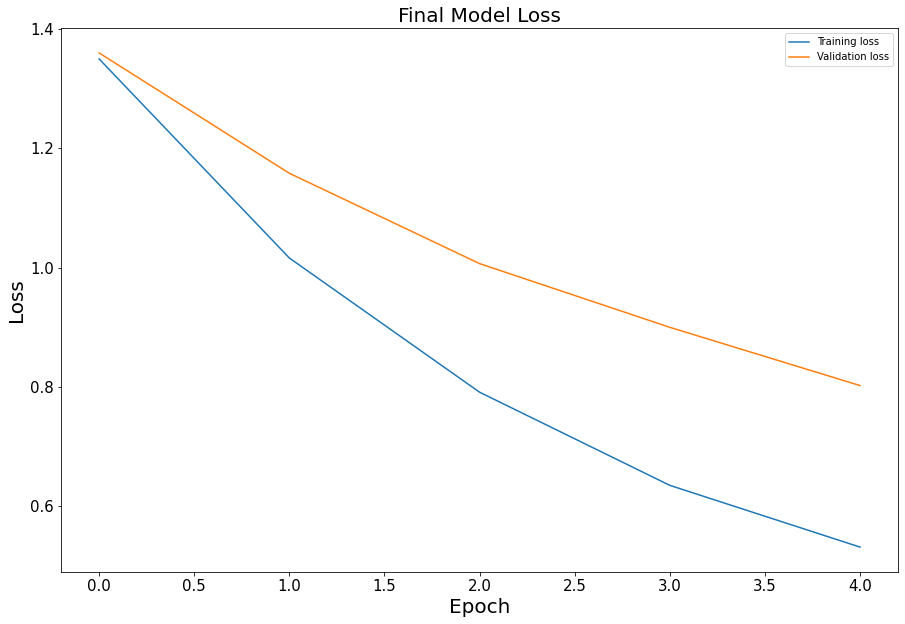

In [29]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Final Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training loss', 'Validation loss'], loc='upper right')
plt.show()

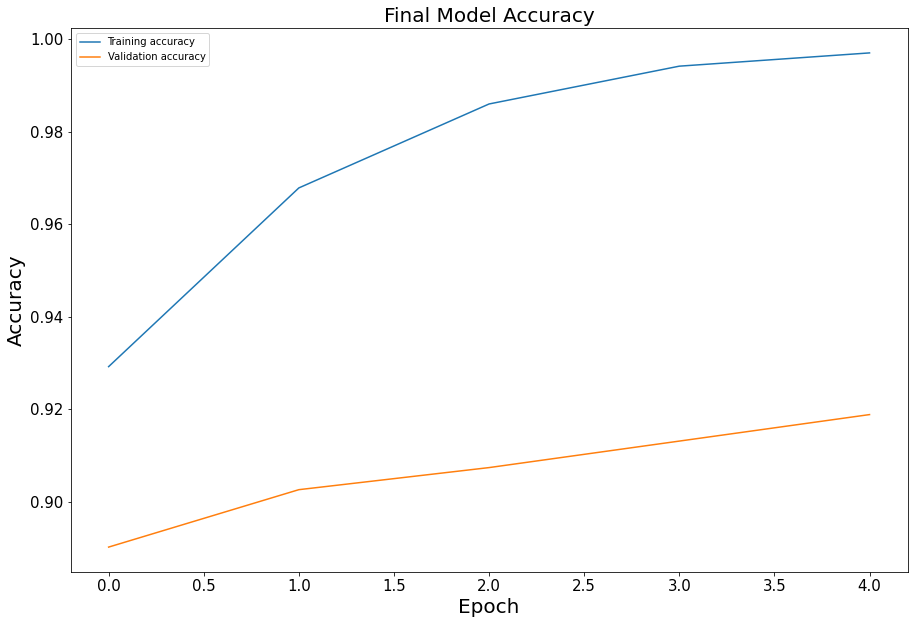

In [30]:
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('Final Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training accuracy', 'Validation accuracy'], loc='upper left')
plt.show()

<AxesSubplot:>

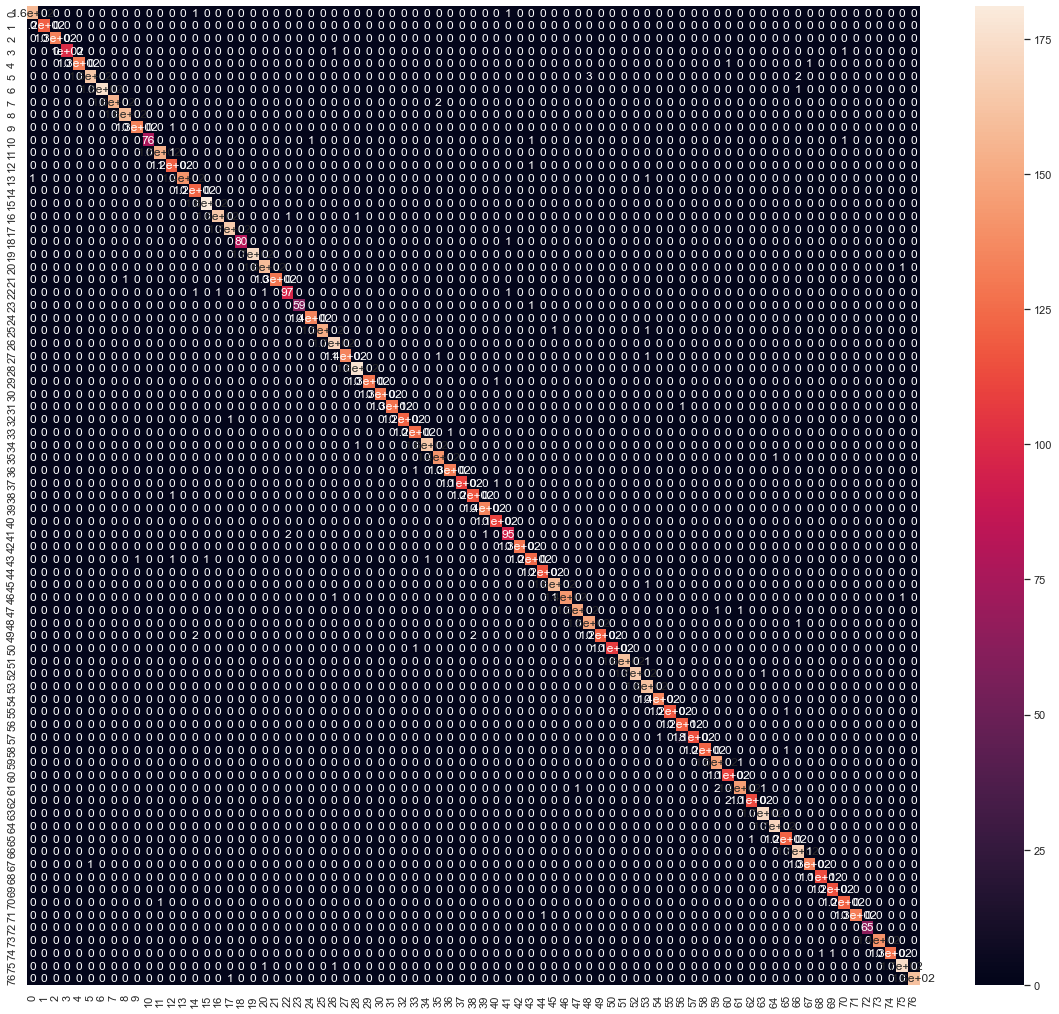

In [31]:
import seaborn as sns

pred = realistic_model.predict([test_text['input_ids'], test_text['attention_mask']])
cf_matrix = tf.math.confusion_matrix(test_labels.argmax(axis=1), pred.argmax(axis=1))
sns.set(rc={'figure.figsize':(20,18)})
sns.heatmap(cf_matrix, annot=True)

In [32]:
eval = realistic_model.evaluate([test_text['input_ids'], test_text['attention_mask']], test_labels, verbose=2)

328/328 - 497s - loss: 0.5160 - categorical_accuracy: 0.9905 - 497s/epoch - 2s/step


In [42]:
texttest = tokenizer(
    'Where is my card?', 
    add_special_tokens=True, 
    max_length=98, 
    padding='max_length', 
    truncation=True, 
    return_tensors='tf'
)
predi_test = realistic_model.predict([[texttest['input_ids']], [texttest['attention_mask']]])

print(predi_test.argmax(axis = 1))

[11]
